In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

from scipy import stats
from sklearn.metrics import auc

%matplotlib inline
plt.style.use('seaborn')
sns.set_style("white")
sns.despine()

fwd_headers = """sample,path,chrom,clus_start_chrom,clus_start_align,clust_start1,
clust_end1,sp1_qry,sp1_ref,sp2_ref,sp3_ref,sp4_ref,iden_up,ident_rep,
ident_down,ident_inv,ident_fwd,ident_epo,masked,sum_ins,sum_del,sum_mis,
sum_nuc,CpG,clus_ins,clus_del,clus_mis,fwd_score,ts_score,ts_score_maxj,ts_ref_seq_len,
ts_qry_seq_len,l_one,two_three,four_r""".strip().replace("\n", "").split(",")

ts_headers = """sample,path,switch_points,chrom,clus_start_chrom,clus_start_align,clust_start1,
clust_end1,sp1_qry,sp1_ref,sp2_ref,sp3_ref,sp4_ref,iden_up,ident_rep,
ident_down,ident_inv,ident_fwd,ident_epo,masked,sum_ins,sum_del,sum_mis,
sum_nuc,CpG,clus_ins,clus_del,clus_mis,fwd_score,ts_score,ts_score_maxj,ts_ref_seq_len,
ts_qry_seq_len,l_one,two_three,four_r""".strip().replace("\n", "").split(",")

my_orange = "#E65100"
my_blue = "#061f80"

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

grid_grey = "#e0e0e0"
grey = "#BDBDBD"
border_width = 0.5
threshold_line_width = .75
linewidth = 6.202 # linewidth from latex document

ts_green = "#3D8F24"
ts_purple = "#6E38CC"

sns.set_context("paper", rc={"font.size": 8,
                             "axes.labelsize": 8,
                             "xtick.labelsize": 8,
                             "ytick.labelsize": 8,
                             "legend.fontsize": 8,
                             "axes.titlesize": 8,
                             "legend.title_fontsize": 8,
                             "axes.linewidth": border_width}) 

<Figure size 576x396 with 0 Axes>

In [2]:
def apply_event_filters(df, use=True):
    if use:
        len_df = len(df)
        print("len df:", len_df)
        df = df[df["masked"] == 0]
        len_df = len(df)
        print("len df after masking:", len_df)
        #df = df[df["sum_nuc"] == 4]
        df = df[df["clus_del"] <= 50]
        len_df = len(df)
        print("len df after removing large deletions:", len_df)
        df = df[(df["clus_ins"] >= 1) | (df["clus_mis"] >= 1)]
        len_df = len(df)
        print("len df after removing sole deletions:", len_df)
        df = df[df["iden_up"] > 0.9]
        len_df = len(df)
        print("len df after ident up:", len_df)
        df = df[df["ident_down"] > 0.9]
        len_df = len(df)
        print("len df after ident down:", len_df)
        #df = df[df["four_one"] > 0]
        #df = df[df["ts_ref_seq_len"] < 150]
        df = df[df["lengths"] >= 4]
        len_df = len(df)
        print("len df after 23 length filter:", len_df)
    return df


def add_score_diffs(fpa_df):
    fpa_df['fwd_score'] = pd.to_numeric(fpa_df['fwd_score'])
    fpa_df['ts_score'] = pd.to_numeric(fpa_df['ts_score'])
    fpa_df['score_diff'] = fpa_df['ts_score'] - fpa_df['fwd_score']
    fpa_df['score_D'] = fpa_df['ts_score_maxj'] - fpa_df['fwd_score']
    fpa_df['sp1_ref'] = pd.to_numeric(fpa_df['sp1_ref'])
    fpa_df['sp4_ref'] = pd.to_numeric(fpa_df['sp4_ref'])
    fpa_df['four_one'] = fpa_df["sp4_ref"] - fpa_df["sp1_ref"]
    fpa_df['sp2_ref'] = pd.to_numeric(fpa_df['sp2_ref'])
    fpa_df['sp3_ref'] = pd.to_numeric(fpa_df['sp3_ref'])
    fpa_df['ident_ratio'] = fpa_df["ident_fwd"] / fpa_df["ident_inv"] 
    fpa_df['lengths'] = fpa_df['sp2_ref'] - fpa_df['sp3_ref'] + 1
    return fpa_df


def load_fwd_scanned(fi):
    all_scanned_df = pd.read_csv(fi,
                                 low_memory=False,
                                 index_col=False,
                                 header=None,
                                 names=fwd_headers)
    return apply_event_filters(add_score_diffs(all_scanned_df))


def load_ts_scanned(fi):
    ts_scanned = pd.read_csv(fi,
                             low_memory=False,
                             index_col=False,
                             header=None,
                             names=ts_headers)
    ts_p1 = [i.split("-")[0] for i in list(ts_scanned["switch_points"])]
    ts_scanned["p1"] = ts_p1
    ts_scanned["p1"] = pd.to_numeric(ts_scanned["p1"])
    ts_scanned["p1_diff"] = ts_scanned["p1"] - pd.to_numeric(ts_scanned["sp1_ref"])
    ts_scanned["p1_diff"] = ts_scanned["p1_diff"].abs()
    ts_scanned["sample_path"] = ts_scanned["sample"] + "_" + ts_scanned["path"]
    ts_scanned = ts_scanned.loc[ts_scanned.groupby("sample_path")["p1_diff"].idxmin()]
    return apply_event_filters(add_score_diffs(ts_scanned))

In [479]:
all_false_positives = load_fwd_scanned("simulations/fwd_scanned_fixed_parameters_n_10.csv")
true_positives = load_ts_scanned("simulations/ts_scanned_fixed_parameters_n_10.csv")

In [480]:
# process simulation data
roc_recall = [0]
threshold_l = []
roc_fpra = [0]

thresh=100
for i in range(1, thresh, 1):
    threshold = max(sorted(all_false_positives["score_diff"], reverse=True)[round(len(all_false_positives["score_diff"]) * i/thresh):])
    threshold_l.append(threshold)
    roc_recall.append(len(true_positives[true_positives.score_diff >= threshold].index) / len(true_positives.score_diff.index))
    roc_fpra.append(len(all_false_positives[all_false_positives.score_diff >= threshold].index) / (len(all_false_positives.index)))

all_false_positives["score_diff"].max(), threshold_l[:5]

a = auc(roc_fpra, roc_recall)

In [546]:
sample_fprs = []
sample_recalls = []
sample_threshold_lists = []
sample_aucs = []

for sample in all_false_positives["sample"].unique():
    roc_recall = [0]
    threshold_l = []
    roc_fpra = [0]

    sample_fps = all_false_positives[all_false_positives["sample"] == sample]
    sample_tps = true_positives[true_positives["sample"] == sample]

    thresh=100
    try:
        for i in range(1, thresh, 1):
            try:
                threshold = max(sorted(sample_fps["score_diff"], reverse=True)[round(len(sample_fps["score_diff"]) * i/thresh):])
            except ValueError:
                threshold = min(sorted(sample_fps["score_diff"], reverse=True))
            threshold_l.append(threshold)
            roc_recall.append(len(sample_tps[sample_tps.score_diff >= threshold].index) / len(sample_tps.score_diff.index))
            roc_fpra.append(len(sample_fps[sample_fps.score_diff > threshold].index) / (len(sample_fps.index)))
        sample_threshold_lists.append(threshold_l)
        sample_fprs.append(roc_fpra)
        sample_recalls.append(roc_recall)
        
    except ZeroDivisionError:
        continue

for i,j in enumerate(sample_fprs):
    sample_fprs[i] = np.array(j)
    sample_fprs[i][sample_fprs[i]==0] += 0.000001
    sample_fprs[i][0] = 0
    sample_fprs[i] = np.append(sample_fprs[i], 1)

for i,j in enumerate(sample_recalls):
    sample_recalls[i] = np.array(j)
    sample_recalls[i][sample_recalls[i]==0] += 0.000001
    sample_recalls[i][0] = 0
    sample_recalls[i] = np.append(sample_recalls[i], 1)

for i,j in zip(sample_fprs,sample_recalls):
    sample_aucs.append(auc(i, j))

roc_fpr_mean = np.array(sample_fprs).mean(axis=0)
roc_fpr_std = np.array(sample_fprs).std(axis=0)

roc_recall_mean = np.array(sample_recalls).mean(axis=0)
roc_recall_std = np.array(sample_recalls).std(axis=0)

sample_aucs = np.array(sample_aucs)

auc_mean = sample_aucs.mean()
auc_std = sample_aucs.std()

In [560]:
threshes = [i[0] for i in sample_threshold_lists]

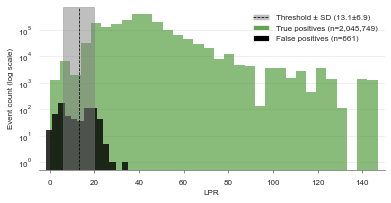

In [562]:
fig, ax = plt.subplots(figsize=(linewidth,round(linewidth/2)))

alpha = .8

hist1 = sns.histplot(true_positives.score_diff,
             color="#3B8F24",
             label="True positives (n={})".format(len(true_positives)),
             ax=ax,
             alpha=.6,
             bins=50,
             linewidth=0)
hist2 = sns.histplot(all_false_positives.score_diff,
             color="black",
             label="False positives (n={})".format(len(all_false_positives)),
             #label="False positives (n={0})".format(len(all_false_positives.index)),
             ax=ax,
             alpha=alpha,
             linewidth=0)

threshes = np.array([i[0] for i in sample_threshold_lists])
threshold_index = round(threshes.mean(), 1)
thresh_std = threshes.std()

p1 = ax.axvline(threshold_index, 0,
              linestyle="--",
              color="black",
              linewidth=threshold_line_width,
              label="Threshold = {0:.1f}".format(threshold_index))

ax.axvspan(threshold_index-thresh_std, threshold_index+thresh_std, alpha=0.5, color='grey',
           label="Threshold ± SD")

ax.tick_params(bottom=True,
            axis="x",
            length=3,
            width=border_width)
ax.tick_params(bottom=True,
            axis="y",
            length=0,
            which="both",
            width=border_width)
ax.set_axisbelow(True)

ax.yaxis.grid(color="#e0e0e0",
                 linewidth=border_width)

p1 = ax.plot(np.NaN, np.NaN, color="black", linewidth=threshold_line_width, linestyle="dashed")
p2 = ax.fill(np.NaN, np.NaN, "grey", alpha=0.5)
p3 = ax.fill(np.NaN, np.NaN, "#3B8F24", alpha=alpha)
p4 = ax.fill(np.NaN, np.NaN, "black")

ax.legend([(p2[0], p1[0]), p3[0], p4[0]], ["Threshold ± SD ({}±{})".format(threshold_index, round(thresh_std, 1)),
                                           "True positives (n={})".format(format(len(true_positives), ",")),
                                           "False positives (n={})".format(len(all_false_positives))])

#ax.legend()
ax.set_yscale("log")

ax.set_xlabel("LPR")
ax.set_ylabel("Event count (log scale)")

ax.set_xlim(-5,150)

sns.despine(left=True)

plt.savefig("test_dist.pdf",
            format="pdf",
            bbox_inches="tight")

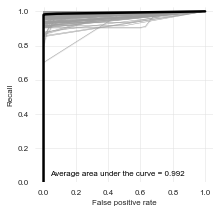

In [555]:
fig, ax = plt.subplots(figsize=(linewidth/2,round(linewidth/2)))

for f,r in zip(sample_fprs, sample_recalls):
    sns.lineplot(x=f, y=r,
                    color="#9E9E9E",
                    linewidth=.5)

sns.lineplot(x=roc_fpr_mean, y=roc_recall_mean,
                color="black",
                linewidth=2.5)

ax.set_ylim(0.0,1.025)

ax.tick_params(bottom=True,
                axis="x",
                length=0,
                width=border_width)
ax.tick_params(bottom=True,
                axis="y",
                length=0,
                which="both",
                width=border_width)
ax.set_axisbelow(True)

ax.yaxis.grid(color="#e0e0e0",
                 linewidth=border_width)
ax.xaxis.grid(color="#e0e0e0",
                 linewidth=border_width)
sns.despine(left=True, bottom=True)

ax.set_ylabel("Recall")
ax.set_xlabel("False positive rate")

ax.text(.04, .04,
        "Average area under the curve = {}".format(round(mean_auc, 3)),
        color="black")

fig.tight_layout()

plt.savefig("test_roc.pdf",
            format="pdf",
            bbox_inches="tight")

In [4]:
file_pairs = [["fwd_scanned_fixed_parameters_n_1.csv", "ts_scanned_fixed_parameters_n_1.csv"],
              ["fwd_scanned_fixed_parameters_n_5.csv", "ts_scanned_fixed_parameters_n_5.csv"],
              ["fwd_scanned_fixed_parameters_n_10.csv", "ts_scanned_fixed_parameters_n_10.csv"],
              ["fwd_scanned_sample_parameters_n_1.csv", "ts_scanned_sample_parameters_n_1.csv"],
              ["fwd_scanned_sample_parameters_n_5.csv", "ts_scanned_sample_parameters_n_5.csv"],
              ["fwd_scanned_sample_parameters_n_10.csv", "ts_scanned_sample_parameters_n_10.csv"],
              ["fwd_scanned_pop_parameters.csv", "ts_scanned_pop_parameters.csv"]]

In [5]:
# generate all

sample_fpr_dic = {}
sample_recall_dic = {}
sample_threshold_list_dic = {}
sample_auc_dic = {}

sample_mean_fpr_dic = {}
sample_mean_recall_dic = {}
sample_std_fpr_dic = {}
sample_std_recall_dic = {}

sample_tp_score_diff_dic = {}
sample_fp_score_diff_dic = {}


for fi_pair in file_pairs:
    print("fi pair:", fi_pair[0])
    fp_fi, tp_fi = fi_pair[0], fi_pair[1]
    all_false_positives = load_fwd_scanned("simulations/" + fp_fi)
    true_positives = load_ts_scanned("simulations/" + tp_fi)

    sample_tp_score_diff_dic[fp_fi] = list(true_positives.score_diff)
    sample_fp_score_diff_dic[fp_fi] = list(all_false_positives.score_diff)

    sample_fprs = []
    sample_recalls = []
    sample_threshold_lists = []
    sample_aucs = []

    for sample in all_false_positives["sample"].unique():
        roc_recall = [0]
        threshold_l = []
        roc_fpra = [0]

        sample_fps = all_false_positives[all_false_positives["sample"] == sample]
        sample_tps = true_positives[true_positives["sample"] == sample]

        thresh=100
        try:
            for i in range(1, thresh, 1):
                try:
                    threshold = max(sorted(sample_fps["score_diff"], reverse=True)[round(len(sample_fps["score_diff"]) * i/thresh):])
                except ValueError:
                    threshold = min(sorted(sample_fps["score_diff"], reverse=True))
                threshold_l.append(threshold)
                roc_recall.append(len(sample_tps[sample_tps.score_diff >= threshold].index) / len(sample_tps.score_diff.index))
                roc_fpra.append(len(sample_fps[sample_fps.score_diff > threshold].index) / (len(sample_fps.index)))
            sample_threshold_lists.append(threshold_l)
            sample_fprs.append(roc_fpra)
            sample_recalls.append(roc_recall)
            
        except ZeroDivisionError:
            continue

    for i,j in enumerate(sample_fprs):
        sample_fprs[i] = np.array(j)
        sample_fprs[i][sample_fprs[i]==0] += 0.000001
        sample_fprs[i][0] = 0
        sample_fprs[i] = np.append(sample_fprs[i], 1)

    for i,j in enumerate(sample_recalls):
        sample_recalls[i] = np.array(j)
        sample_recalls[i][sample_recalls[i]==0] += 0.000001
        sample_recalls[i][0] = 0
        sample_recalls[i] = np.append(sample_recalls[i], 1)

    for i,j in zip(sample_fprs,sample_recalls):
        sample_aucs.append(auc(i, j))

    roc_fpr_mean = np.array(sample_fprs).mean(axis=0)
    roc_fpr_std = np.array(sample_fprs).std(axis=0)

    roc_recall_mean = np.array(sample_recalls).mean(axis=0)
    roc_recall_std = np.array(sample_recalls).std(axis=0)

    sample_aucs = np.array(sample_aucs)

    sample_fpr_dic[fp_fi] = sample_fprs
    sample_recall_dic[fp_fi] = sample_recalls
    sample_threshold_list_dic[fp_fi] = sample_threshold_lists
    sample_auc_dic[fp_fi] = sample_aucs

    sample_mean_fpr_dic[fp_fi] = roc_fpr_mean
    sample_std_fpr_dic[fp_fi] = roc_fpr_std

    sample_mean_recall_dic[fp_fi] = roc_recall_mean
    sample_std_recall_dic[fp_fi] = roc_recall_std
    print("\n")

fi pair: fwd_scanned_fixed_parameters_n_1.csv
len df: 20388
len df after masking: 20388
len df after removing large deletions: 18904
len df after removing sole deletions: 9334
len df after ident up: 6134
len df after ident down: 3395
len df after 23 length filter: 662
len df: 2935723
len df after masking: 2935723
len df after removing large deletions: 2935700
len df after removing sole deletions: 2201779
len df after ident up: 2201445
len df after ident down: 2201135
len df after 23 length filter: 2045924


fi pair: fwd_scanned_fixed_parameters_n_5.csv
len df: 20388
len df after masking: 20388
len df after removing large deletions: 18904
len df after removing sole deletions: 9334
len df after ident up: 6137
len df after ident down: 3393
len df after 23 length filter: 658
len df: 2935879
len df after masking: 2935879
len df after removing large deletions: 2935861
len df after removing sole deletions: 2201624
len df after ident up: 2201289
len df after ident down: 2201018
len df after 23

In [12]:
process_list = ['fwd_scanned_sample_parameters_n_1.csv',
                'fwd_scanned_sample_parameters_n_5.csv',
                'fwd_scanned_sample_parameters_n_10.csv',
                'fwd_scanned_fixed_parameters_n_1.csv',
                'fwd_scanned_fixed_parameters_n_5.csv',
                'fwd_scanned_fixed_parameters_n_10.csv',
                'fwd_scanned_pop_parameters.csv']

In [11]:
plot_titles = {
    'fwd_scanned_sample_parameters_n_1.csv':  "Sample-specific parameters, N=1",
    'fwd_scanned_sample_parameters_n_5.csv':  "Sample-specific parameters, N=5",
    'fwd_scanned_sample_parameters_n_10.csv': "Sample-specific parameters, N=10",
    'fwd_scanned_fixed_parameters_n_1.csv':  "Cancer-wide parameters, N=1",
    'fwd_scanned_fixed_parameters_n_5.csv':  "Cancer-wide parameters, N=5",
    'fwd_scanned_fixed_parameters_n_10.csv':  "Cancer-wide parameters, N=10",
    'fwd_scanned_pop_parameters.csv': "Human population parameters"
 }

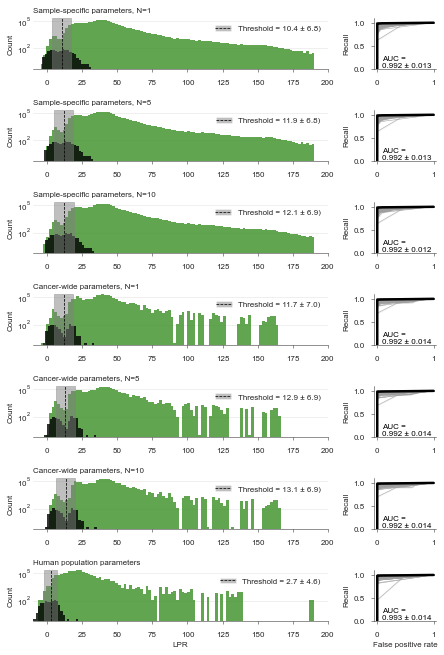

In [14]:
fig, ax = plt.subplots(7,2,figsize=(linewidth,round(linewidth)*1.5),gridspec_kw={'width_ratios': [4.75, 1]})

# predefine bins for consistency across subplots
bins = np.histogram_bin_edges(sample_tp_score_diff_dic["fwd_scanned_pop_parameters.csv"], bins=100)

ax_keys = [[0,0],[0,1],
           [1,0],[1,1],
           [2,0],[2,1],
           [3,0],[3,1],
           [4,0],[4,1],
           [5,0],[5,1],
           [6,0],[6,1]]

ax_n = 0

for fp_fi in process_list:
    # process score diffs
    true_positives = sample_tp_score_diff_dic[fp_fi]
    all_false_positives = sample_fp_score_diff_dic[fp_fi]

    # process lpr thresholds
    sample_threshold_lists = sample_threshold_list_dic[fp_fi]
    threshes = np.array([i[0] for i in sample_threshold_lists])
    threshold_index = round(threshes.mean(), 1)
    thresh_std = threshes.std()

    # process sample roc info
    sample_fprs = sample_fpr_dic[fp_fi]
    sample_recalls = sample_recall_dic[fp_fi]

    # process mean roc info
    roc_fpr_mean = sample_mean_fpr_dic[fp_fi]
    roc_recall_mean = sample_mean_recall_dic[fp_fi]

    # process aucs
    sample_aucs = sample_auc_dic[fp_fi]
    mean_auc = np.array(sample_aucs).mean()
    std_auc = np.array(sample_aucs).std()

    alpha = .8
    ax_counter = 0
    hist1 = sns.histplot(true_positives,
                color="#3B8F24",
                label="True positives (n={})".format(len(true_positives)),
                ax=ax[ax_n][0],
                alpha=.8,
                bins=bins,
                linewidth=0)
    hist2 = sns.histplot(all_false_positives,
                color="black",
                label="False positives (n={})".format(len(all_false_positives)),
                ax=ax[ax_n][0],
                bins=20,
                alpha=alpha,
                linewidth=0)

    p1 = ax[ax_n][0].axvline(threshold_index, 0,
                linestyle="--",
                color="black",
                linewidth=threshold_line_width,
                label="Threshold = {0:.1f}".format(threshold_index))
    ax[ax_n][0].axvspan(threshold_index-thresh_std, threshold_index+thresh_std, alpha=0.5, color='grey',
            label="Threshold ± SD")
    ax[ax_n][0].tick_params(bottom=True,
                axis="x",
                length=3,
                width=border_width)
    ax[ax_n][0].tick_params(bottom=True,
                axis="y",
                length=0,
                pad=2,
                which="both",
                width=border_width)
    ax[ax_n][0].set_axisbelow(True)
    ax[ax_n][0].yaxis.grid(color="#e0e0e0",
                    linewidth=border_width)
    p1 = ax[ax_n][0].plot(np.NaN, np.NaN, color="black", linewidth=threshold_line_width, linestyle="dashed")
    p2 = ax[ax_n][0].fill(np.NaN, np.NaN, "grey", alpha=0.5)
    p3 = ax[ax_n][0].fill(np.NaN, np.NaN, "#3B8F24", alpha=alpha)
    p4 = ax[ax_n][0].fill(np.NaN, np.NaN, "black")
    ax[ax_n][0].legend([(p2[0], p1[0])], ["Threshold = {} ± {})".format(threshold_index, round(thresh_std, 1))],
                 frameon=False,
                 loc="upper right")
    ax[ax_n][0].set_yscale("log")
    ax[ax_n][0].set_xlabel("")
    ax[ax_n][0].set_ylabel("Count")
    ax[ax_n][0].set_xlim(-10,200)
    ax[ax_n][0].set_ylim(top=200000)

    ax[ax_n][0].set_title(plot_titles[fp_fi], loc="left")

    sns.despine(left=True, ax=ax[ax_n][0])

    for f,r in zip(sample_fprs, sample_recalls):
        sns.lineplot(x=f, y=r,
                        color="#9E9E9E",
                        linewidth=.5,
                    ax=ax[ax_n][1])

    sns.lineplot(x=roc_fpr_mean, y=roc_recall_mean,
                    color="black",
                    linewidth=2.5,
                    ax=ax[ax_n][1])

    ax[ax_n][1].set_ylim(0.0,1.1)

    ax[ax_n][1].tick_params(bottom=True,
                    axis="x",
                    length=3,
                    width=border_width)
    ax[ax_n][1].tick_params(bottom=True,
                    left=True,
                    axis="y",
                    length=3,
                    which="both",
                    width=border_width)
    ax[ax_n][1].set_axisbelow(True)

    sns.despine(ax=ax[ax_n][1])

    ax[ax_n][1].set_ylabel("Recall")
    ax[ax_n][1].set_xlabel("")

    ax[ax_n][1].text(.08, .04,
            "AUC =\n{} ± {}".format(round(mean_auc, 3), round(std_auc, 3)),
            color="black")
    ax_n += 1

    fig.tight_layout()

plt.subplots_adjust(hspace=.8)
ax[ax_n-1][0].set_xlabel("LPR")
ax[ax_n-1][1].set_xlabel("False positive rate")

plt.savefig("test_dist.pdf",
            format="pdf",   
            bbox_inches="tight")